<p style="padding: 10px;
          font-size:50px;
          font-weight: bolder;
          color: rgba(124, 203, 234, 0.75)">
    Microcirculation
</p>

<a name="000" style="color: black">
    <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
        Table of Сontents
    </p>
</a>

<div style="padding: 20px;
            margin-top: 20px;
            color: black;
            background: rgba(124,203,234,0.25)">
    <ol>
        <li><a href="#001">Model Configuration</a></li>
        <li><a href="#002">Training Results</a></li>
        <li><a href="#003">Validation Results</a></li>
    </ol>
</div>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import segmentation_models_pytorch as smp

import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.utils import draw_segmentation_masks
import matplotlib.pyplot as plt
import shutil
import pickle
import gdown
import json
import glob
import os

from training import EyeDataset

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="001" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Model Configuration
        </p>
    </a>
</blockquote>

#### UNet++: A Nested U-Net Architecture

<img width="512" src="https://user-images.githubusercontent.com/83948828/193248289-2b244aa9-1c5b-4325-9768-10a8db01ff41.jpg" alt="U-Net++">

$(a)$ ***UNet++*** consists of an encoder and decoder that are connected through a series of nested dense convolutional blocks. The main idea behind ***UNet++*** is to bridge the semantic gap between the feature maps of the encoder and decoder prior to fusion. For example, the semantic gap between $(X^{0,0}, X^{1,3})$ is bridged using a dense convolution block with three convolution layers. In the graphical abstract, black indicates the original ***U-Net***, green and blue show dense convolution blocks on the skip pathways, and red indicates deep supervision. Red, green, and blue components distinguish ***UNet++*** from ***U-Net***. $(b)$ Detailed analysis of the first skip pathway of ***UNet++***. $(c)$ ***UNet++*** can be pruned at inference time, if trained with deep supervision.

#### Reference

*Zhou, Z. et al. (2018) "UNet++: A Nested U-Net Architecture for Medical Image Segmentation". arXiv. doi: 10.48550/ARXIV.1807.10165.*

#### PyTorch Implementation

In [2]:
pretrained = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = smp.UnetPlusPlus("resnet101", activation="logsoftmax", classes=2)
model = nn.DataParallel(model).to(device).eval()

In [3]:
if pretrained:
    path = "https://drive.google.com/uc?export=view&id=1X5HRWB0wml2xAJ1iDYKKYSrTAcO2tHyh"
    model_name = "unetpp_resnet_101.pt"
    os.makedirs("weights", exist_ok=True)
    cached_file = os.path.join("weights", os.path.basename(model_name))
    
    if not os.path.exists(cached_file):
        gdown.download(path, cached_file, quiet=False)
    
    checkpoint = torch.load(cached_file, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"], strict=True)

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="002" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Training Results
        </p>
    </a>
</blockquote>

#### Data Augmentation

In [4]:
image_size = 1024

eval_list = [
    A.RandomResizedCrop(width=1550, height=1550),
    A.LongestMaxSize(image_size, interpolation=cv2.INTER_CUBIC),
    A.Rotate(limit=15),
    A.PadIfNeeded(image_size, image_size),
    ToTensorV2(transpose_mask=True)
]

transforms = {"test": A.Compose(eval_list)}
dataset = EyeDataset("data/train_dataset")

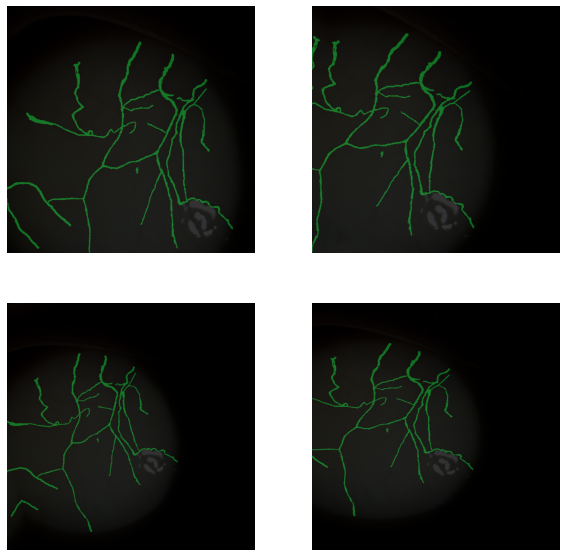

In [5]:
figure, ax = plt.subplots(2, 2, figsize=(10, 10))

for i, sample in zip(range(4), dataset):
    transformed = transforms["test"](**sample)
    image, mask = transformed["image"], transformed["mask"]
    
    image_with_mask = draw_segmentation_masks((image.cpu()*255).type(torch.uint8), mask.type(torch.bool))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)
    
    ax[i // 2, (i % 2)].imshow(image_with_mask)
    ax[i // 2, (i % 2)].axis("off")

plt.show()

#### Graphs

In [6]:
def plot_history(train_history, test_history, title):
    plt.figure()
    plt.title("{}".format(title))
    plt.plot(train_history, label="Train", zorder=1)
    
    points = np.array(test_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(test_history))))[1:]
    
    plt.plot(steps, test_history, label="Test", zorder=1)
    plt.xlabel("Steps")
    plt.grid()
    plt.show()

In [7]:
with open("data/summary.pkl", "rb") as file:
    summary = pickle.load(file)

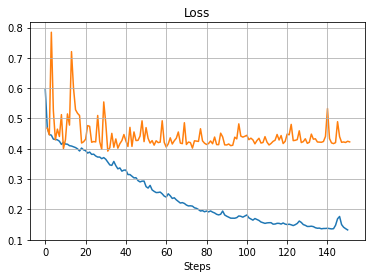

In [8]:
plot_history(summary["loss_train"], summary["loss_test"], "Loss")

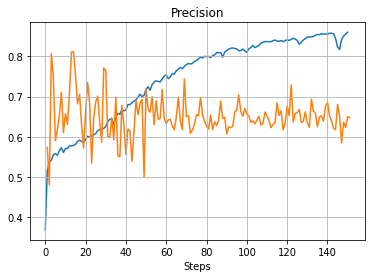

In [9]:
plot_history(summary['accuracy_train'], summary['accuracy_test'], "Precision")

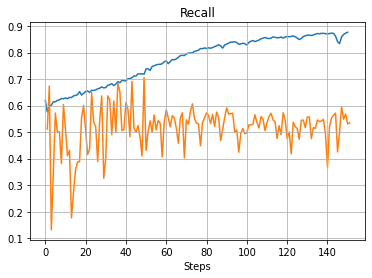

In [10]:
plot_history(summary['recall_train'], summary['recall_test'], "Recall")

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="003" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Validation Results
        </p>
    </a>
</blockquote>

#### Test Data Preparation

In [11]:
class EyeDataset(Dataset):
    """Dataset class organizing the loading and receiving of images.
    """
    
    def __init__(self, data_folder: str, transform = None):
        self.data_folder = data_folder
        self.transform = transform
        self._image_files = glob.glob(f"{data_folder}/*.png")
    
    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image / 255, dtype=np.float32)
        
        return image
    
    def __getitem__(self, idx: int) -> dict:
        image_path = self._image_files[idx]
        image = self.read_image(image_path)
        
        sample = {"image": image, "path": image_path}
        
        if self.transform is not None:
            sample = self.transform(**sample)
        
        return sample
    
    def __len__(self):
        return len(self._image_files)


class DatasetPart(Dataset):
    """Wrapper over the dataset class for splitting it into parts.
    """
    
    def __init__(self, dataset: Dataset, indices: np.ndarray, transform: A.Compose = None):
        self.dataset = dataset
        self.indices = indices
        
        self.transform = transform
    
    def __getitem__(self, idx: int) -> dict:
        sample = self.dataset[self.indices[idx]]
        
        if self.transform is not None:
            sample = self.transform(**sample)
        
        return sample
    
    def __len__(self) -> int:
        return len(self.indices)

In [12]:
pre_list = [
    A.LongestMaxSize(1024, interpolation=cv2.INTER_CUBIC),
    A.PadIfNeeded(1024, 1024),
    ToTensorV2(transpose_mask=True),
]

post_list = [
    A.LongestMaxSize(1624, interpolation=cv2.INTER_CUBIC),
    A.CenterCrop(1232, 1624)
]

transforms = {"pre": A.Compose(pre_list), "post": A.Compose(post_list)}

dataset = EyeDataset("data/eye_test")
val_dataset = DatasetPart(dataset, range(len(dataset)), transform=transforms["pre"])

#### Model Inference

In [ ]:
os.makedirs("sample_solution", exist_ok=True)

with torch.no_grad():
    for _, sample in zip(range(len(val_dataset)), val_dataset):
        image, name = sample["image"].to(device), sample["path"]
        
        prediction = model(image.unsqueeze(dim=0)).detach().cpu()
        mask = (torch.exp(prediction[0]) < 0.5).numpy() * 255
        mask = np.transpose(mask, (1, 2, 0)).astype(np.uint8)
        
        image_with_mask = transforms["post"](image=mask)["image"]
        image_with_mask = image_with_mask[:, :, 0]
        
        img_binary = cv2.threshold(image_with_mask, 100, 255, cv2.THRESH_BINARY)[1]
        
        cv2.imwrite(os.path.join("sample_solution", os.path.basename(name)), img_binary)

shutil.make_archive("sample_solution", "zip", "sample_solution")

<a href="#000">Back to content</a>